## Riemann Optimization and Gradient Descent

Optimization in Riemann space is a little different than standard stochastic gradient descent which is applied in traditional Euclidean deep learning. In the real space, certain optimizations are performed on manifold data (such as geodesics) which operate in a different subspace. A comparison of  different Euclidean optimizers - SGD,Momentum,Adagrad,Adadelta,Rmsprop,Nesterov  have been shown in this figure (taken from [Sebastian Ruder's blog](https://ruder.io/optimizing-gradient-descent/))
<img src="https://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif">


In this notebook, we will be looking at how to implement a SGD optimizer for the Riemannian manifold.A traditional Stochastic gradient descent applies the following principle:

$$ SGD: \theta_{t+1}=\theta_{t} - \lambda\nabla L$$

For Riemann Gradient Descent, we have to additionally apply an exponential mapping. This is because, we have to map the change in tensor or vector (along the gradient) on the manifold space. Optimizations are done in vector space and then projected back into the manifold.

$$RSGD: \theta_{t+1}=\theta_{t} + exp(- \lambda\nabla_{R} L)$$

where exp stands for exponential mapping : $$\tau_{\theta} M -> M$$
$\nabla_{R}$ is the Riemann gradient given by $(g_{\theta})^{-1}\nabla L$ where $g_{\theta}$ is the metric tensor. For euclidean domain, exponential map is an addition (mentioned in [previous lectures](https://github.com/abhilash1910/AI-Geometric-Learning/blob/master/Chapter_1_Introduction/Euclidean_Manifold.ipynb)) as such:

$$exp_{\theta_{t}}(v)=\theta + v$$ and the corresponding metric tensor $g_{\theta}$ is an identity matrix. In this case, we are exploring a Riemann projection of the SGD algorithm and we will be using the torch backend for implementing it.

The steps for implementing are as follows:

- Intializing an optimizer class from [torch.optim.Optimizer](https://pytorch.org/docs/stable/optim.html) module
- In this case,we are taking the gradient of a point (tensor) and then projecting that gradient through an inner product. This is conversion to localised vector space. 
- The learning rate is applied for the gradient computation.
- The next step involves projecting the values back to manifold (Exponential mapping). The grad vector as well as the original vector are mapped in the Riemann manifold.

In order to test the optimizer,[Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) is used.

In [37]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

In [32]:
import torch
from typing import Tuple
from torch import Tensor
import itertools    


def expm(p : torch.Tensor, u : torch.Tensor):
  """Exponential mapping for hyperbolic spaces"""
  ldv = inner_product(u, u, keepdim=True).clamp_(min=1e-15).sqrt_()
  return torch.cosh(ldv) * p + torch.sinh(ldv) * u / ldv

# def broadcast_shapes(self,*shapes: Tuple[int]) -> Tuple[int]:
#   """Helper function for broadcasting numpy tensors. Taken from Euclidean manifolds notebook"""
#   result = []
#   for dims in itertools.zip_longest(*map(reversed, shapes), fillvalue=1):
#       dim: int = 1
#       for d in dims:
#           if dim != 1 and d != 1 and d != dim:
#               raise ValueError("Shapes can't be broadcasted")
#           elif d > dim:
#               dim = d
#       result.append(dim)
#   return tuple(reversed(result))   

@torch.jit.script
def get_gradient(p : torch.Tensor):
  """Computes the gradient and then narrows it to suit the tensor ranks"""
  d_p = p.grad
  d_p.narrow(-1, 0, 1).mul_(-1)
  return d_p

def projection(p: torch.Tensor,d_p:torch.Tensor):
  """Projection mapping using Inner product or point and gradient of point"""
  return d_p + inner_product(p.data, d_p, keepdim=True) * p.data

def inner_product(u : torch.Tensor, v : torch.Tensor, keepdim=False):
  """Inner product of the point and gradient of point"""
  uv = u * v
  uv.narrow(-1, 0, 1).mul_(-1)
  return torch.sum(uv, dim=-1, keepdim=keepdim)


# def egrad2rgrad( x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
#   """Exponential mapping taken from Euclidean manifolds notebook"""
#   target_shape = broadcast_shapes(x.shape, u.shape)
#   return u.expand(target_shape)

class RiemanSGD(torch.optim.Optimizer):
  def __init__(self,params,lr=1e-3,momentum=0):
    """Initializing a default dictionary of parameters"""
    defaults=dict(lr=lr,
            momentum=momentum)
    super(RiemanSGD,self).__init__(params,defaults)
    
  def step(self,lr):
    """Computes the gradient through torch backend graph. 
      1. Takes the non leaf data point  and computes the gradient
      2. Uses the gradient along with the point data to find the inner projection mapping
      3. Applies learning rate on the output
      4. Converts the projected gradients back to the manifold
    
    """
    loss=None
    with torch.enable_grad():
      loss=torch.tensor([10.])
    for group in self.param_groups:
      momentum = group['momentum']
      lr=group['lr']
      for point in group["params"]:
        print(point)
        grad=point.grad
        print("Gradient Values:",grad.data)
        if grad is None:
          continue
        d_point=get_gradient(point)
        d_point=projection(point,d_point)
        print("Applying projection",d_point.data)
        d_point.mul_(-lr)
        y_point=d_point.data
        print("After applying learning rate",point.data,d_point.data)
        #point.add_(d_point)
        point.data.copy_(expm(point.data,d_point))
        print("Exponential map of the points",point.data)
    
    return loss,point.data,y_point


def rosenbrock_loss(tensor):
    """Rosenbrock function as loss"""
    x, y = tensor
    return (1 - x) ** 2 + 1 * (y - x ** 2) ** 2,x,y


if __name__=="__main__":
  """Driver code to test the RSGD optimizer"""
  lists_x=[]
  lists_y=[]
  lx=[]
  ly=[]
  """Initial testing states"""
  initial_state=(1.5, 1.5)
  min_loc=(1, 1)
  u=torch.Tensor(initial_state).requires_grad_(True)
  v=torch.Tensor(min_loc)
  """Passing the hyperparameters and epochs and then the input tensor
      Stores all the gradients and points in separate lists
  """
  lr=1e-3
  iterations=30
  optimizer=RiemanSGD([u])
  for j in range(iterations):
    print(f"Start of epoch: {j}")
    optimizer.zero_grad()
    f,x,y = rosenbrock_loss(u)
    lx.append(x.detach().numpy())
    ly.append(y.detach().numpy())
    f.backward(retain_graph=True, create_graph=True)
    l,p,d_p=optimizer.step(lr)
    lists_x.append(p.numpy()[0])
    lists_y.append(p.numpy()[1])
print("Completion of non convex Optimization")
print("After completion, there will be a corresponding value for each z and y corrdinate on the loss.The z value contains the gradient values as well as final leaf tensor values after each iteration. ")


Start of epoch: 0
tensor([1.5000, 1.5000], requires_grad=True)
Gradient Values: tensor([ 5.5000, -1.5000])
Applying projection tensor([3.5000, 7.5000])
After applying learning rate tensor([1.5000, 1.5000]) tensor([-0.0035, -0.0075])
Exponential map of the points tensor([1.4965, 1.4925])
Start of epoch: 1
tensor([1.4965, 1.4925], requires_grad=True)
Gradient Values: tensor([ 5.4652, -1.4942])
Applying projection tensor([3.4373, 7.3845])
After applying learning rate tensor([1.4965, 1.4925]) tensor([-0.0034, -0.0074])
Exponential map of the points tensor([1.4931, 1.4852])
Start of epoch: 2
tensor([1.4931, 1.4852], requires_grad=True)
Gradient Values: tensor([ 5.4313, -1.4885])
Applying projection tensor([3.3766, 7.2725])
After applying learning rate tensor([1.4931, 1.4852]) tensor([-0.0034, -0.0073])
Exponential map of the points tensor([1.4898, 1.4779])
Start of epoch: 3
tensor([1.4898, 1.4779], requires_grad=True)
Gradient Values: tensor([ 5.3983, -1.4830])
Applying projection tensor([3

## Plotting the loss curve

In this case we are using matplotlib to plot the curve.After 30 iterations we see that the convergence is close to 1. 

[[1.4965332 1.4931278 1.4897822 1.4864945 1.483263  1.4800861 1.476962
  1.4738895 1.4708669 1.4678929 1.4649663 1.4620855 1.4592494 1.4564568
  1.4537066 1.4509977 1.448329  1.4456993 1.443108  1.4405539 1.4380361
  1.4355538 1.4331062 1.4306922 1.4283112 1.4259624 1.4236451 1.4213587
  1.4191023 1.4168752]
 [1.4925331 1.4851804 1.4779387 1.4708047 1.4637754 1.4568479 1.4500192
  1.4432869 1.4366481 1.4301004 1.4236416 1.4172691 1.4109808 1.4047745
  1.3986484 1.3926002 1.3866282 1.3807304 1.3749053 1.3691511 1.3634659
  1.3578485 1.3522973 1.3468105 1.3413869 1.3360251 1.3307238 1.3254817
  1.3202974 1.3151698]]


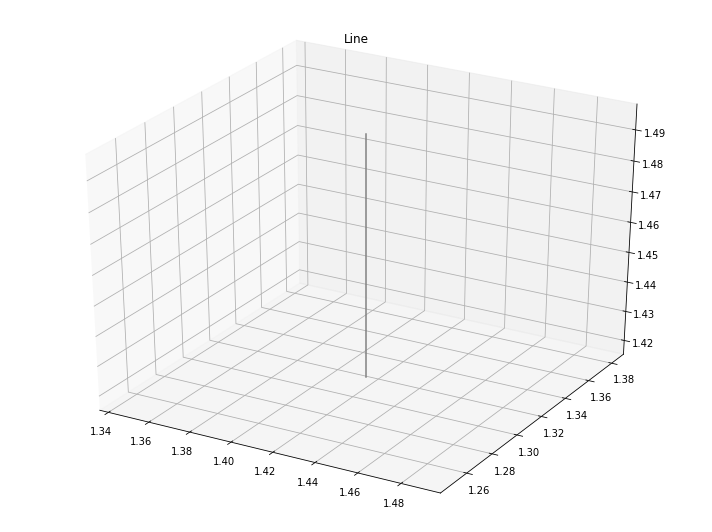

In [67]:
from matplotlib import cm
def rosenbrock_loss_1(x,y):
    return (1 - x) ** 2 + 1 * (y - x ** 2) ** 2

def plotter(lx,ly,z,typ):
  """Plotter function to plot curves"""
  fig = plt.figure(figsize=(10,7.5)) # create figure
  fontsize_=20 # set axis label fontsize
  labelsize_=12 # set tick label size
  ax0 = plt.axes(projection='3d')
  if typ=="plot3D":
    ax0.plot3D(lx,ly, z[0], 'gray')
    # m1s = np.linspace(-5, 3, 30)     
    # m2s = np.linspace(-5, 3, 30)  
    # x, y = np.meshgrid(m1s, m2s) # create meshgrid 
    # z1=rosenbrock_loss_1(x,y)
    # ax0.plot_surface(x,y, z1,cstride=1,cmap='viridis', edgecolor='none')
    ax0.set_title('Line');
 
  else:
    ax0.plot_surface(lx,ly,z,cstride=1,cmap='viridis', edgecolor='none')
    ax0.set_title('surface');
  # Surface plots of costs (= loss landscapes):  
  plt.tight_layout()
  plt.show()

if __name__=='__main__':
  """Convert the lists into numpy nd arrays and replace nans in case"""
  lists_x=np.asarray(lists_x)
  lists_y=np.asarray(lists_y)
  lx=np.asarray(lx)
  ly=np.asarray(ly)
  z=np.array([lists_x,lists_y])
  z=np.nan_to_num(z)
  print(z)
  plotter(lx,ly,z,"plot3D")
  


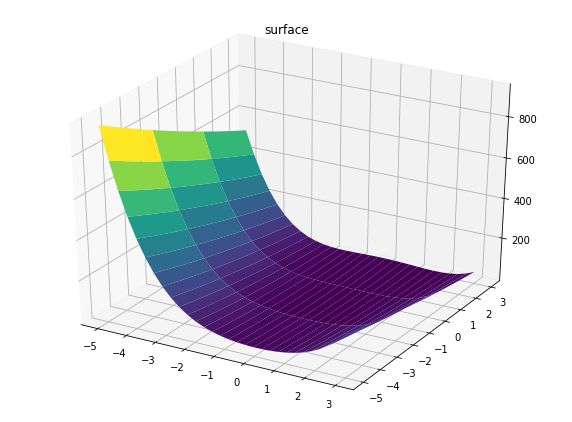

In [69]:
 def plot_rosenbrock():
   #plot rosenbrock 
  fig = plt.figure(figsize=(10,7.5)) # create figure
  fontsize_=20 # set axis label fontsize
  labelsize_=12 # set tick label size
  ax0 = plt.axes(projection='3d')
  #plt rosenbrock
  m1s = np.linspace(-5, 3, 30)     
  m2s = np.linspace(-5, 3, 30)  
  x, y = np.meshgrid(m1s, m2s) # create meshgrid 
  z1=rosenbrock_loss_1(x,y)
  ax0.plot_surface(x,y, z1,cstride=1,cmap='viridis', edgecolor='none')
  ax0.set_title('surface')
  plt.show()
plot_rosenbrock()